In [2]:
#! pip3 install pretrained-backbones-unet

In [3]:
from PIL import Image
from cityscapesscripts.helpers import labels
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import gc
from tqdm.auto import tqdm
import backbones_unet
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from backbones_unet.model.unet import Unet

In [4]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
SEED = 42
set_seeds(SEED)
print(f"Seeds set for reproducibility is {SEED}")

Seeds set for reproducibility is 42


In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.mps.is_available() 
                      else "cpu"
                    )
print(DEVICE)

mps


Actual Colors:


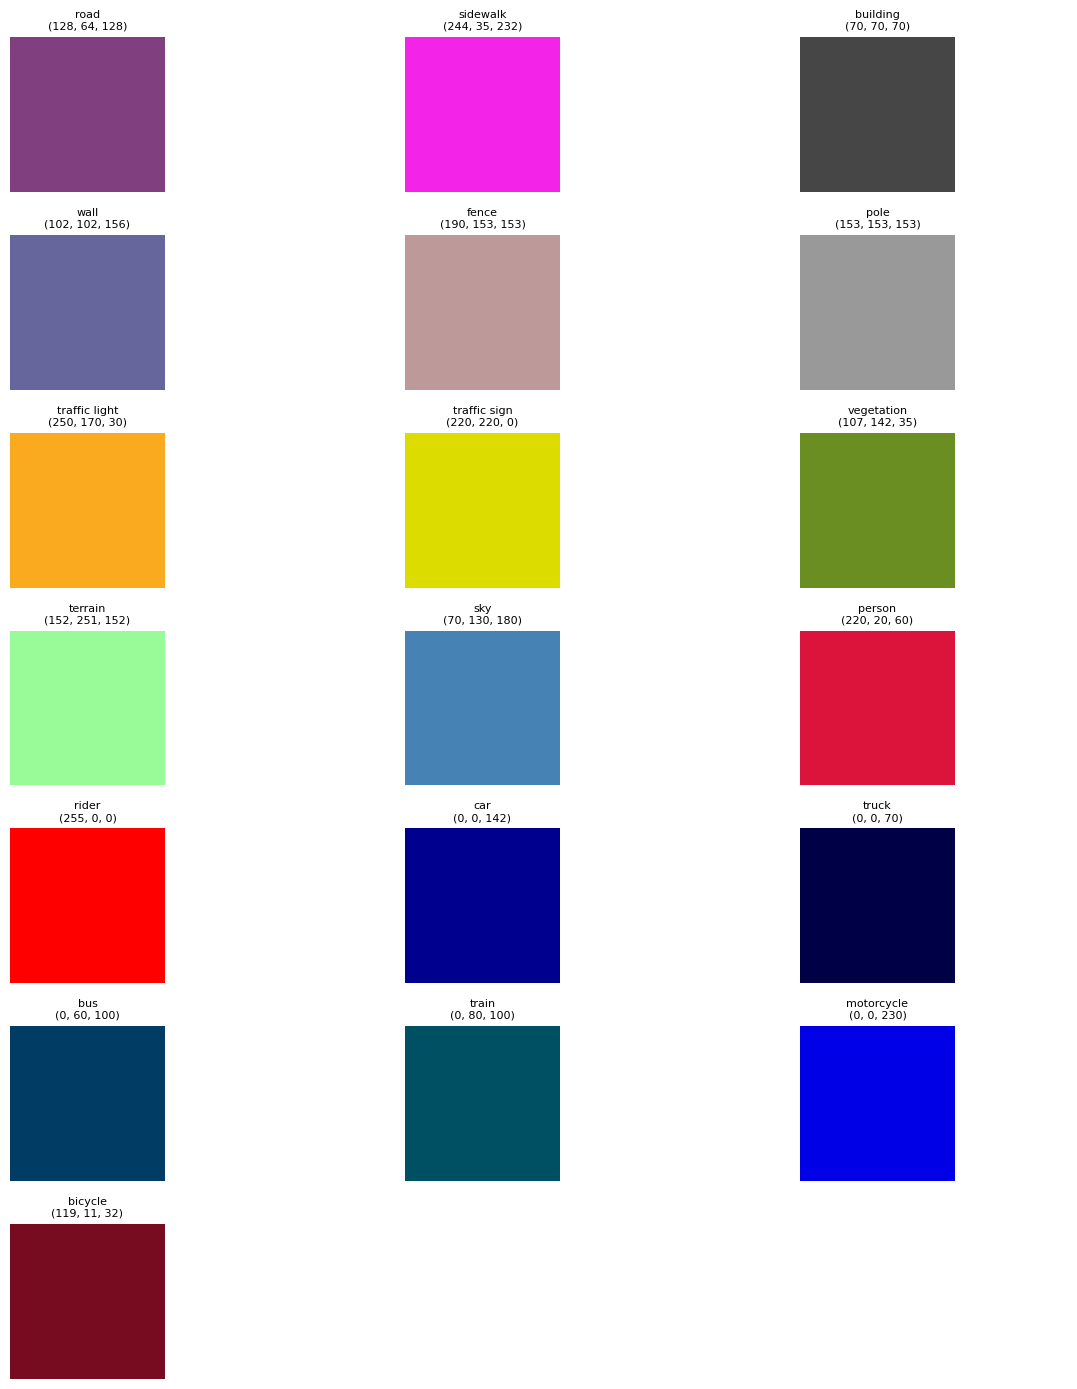

In [6]:
print("Actual Colors:")

# Calculate grid dimensions (3 colors per row)
cols = 3

labels = [label for label in labels.labels if label.trainId != 255 and label.trainId != -1]
rows = (len(labels) + cols - 1) // cols  # Ceiling division

# Create a figure and axes to display the colors in a grid
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 2))

# Flatten axes array for easier indexing
if rows == 1:
    axes = [axes] if cols == 1 else axes
else:
    axes = axes.flatten()

for i, label in enumerate(labels): 
    color = np.array(label.color) / 255.0  # Normalize RGB values to [0, 1]
    axes[i].imshow([[color]])  # Display the color as a small image
    # Add color name and RGB values to the title
    axes[i].set_title(f"{label.name}\n{label.color}", fontsize=8)
    axes[i].axis('off')  # Hide the axes

# Hide any unused subplots
for i in range(len(labels), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, targets_dir, image_transform=None, target_transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            targets_dir (string): Directory with all the target masks.
            image_transform (callable, optional): Optional transform to be applied on images.
            target_transform (callable, optional): Optional transform to be applied on targets.
        """
        self.images_dir = images_dir
        self.targets_dir = targets_dir
        self.image_transform = image_transform
        self.target_transform = target_transform
        
        # Get all image filenames
        self.image_filenames = [f for f in os.listdir(images_dir) 
                               if f.lower().endswith(('.png'))]
        self.image_filenames.sort()
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load target mask
        target_name = img_name.replace('.png', '_trainId.png')
        target_path = os.path.join(self.targets_dir, target_name)
        target = Image.open(target_path)
        
        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.target_transform:
            target = self.target_transform(target)
       # else:
       #     # Default: convert to tensor
       #     target = torch.from_numpy(target)
        
        return image, target

In [8]:
path_images = "syn_resized_images"
path_target = "syn_resized_gt"

image_transform = transforms.Compose([
    transforms.Resize((256, 480)), # We maintain the og aspect ratio
    transforms.ToTensor(),  # Converts PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet parameters
])

target_transform = transforms.Compose([
    transforms.Resize((256, 480), interpolation=Image.NEAREST), # This interpolation ensure that all pixels have a correct value of their class
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
])
syn_dataset = SegmentationDataset(images_dir=path_images, targets_dir=path_target, image_transform=image_transform, target_transform=target_transform)


In [9]:
# Get total dataset size
total_size = len(syn_dataset)
print(f"Total dataset size: {total_size}")

# Calculate split sizes (60% train, 10% val, 30% test)
train_size = int(0.6 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Train size: {train_size} ({train_size/total_size*100:.1f}%)")
print(f"Validation size: {val_size} ({val_size/total_size*100:.1f}%)")
print(f"Test size: {test_size} ({test_size/total_size*100:.1f}%)")

# Create random splits
syn_train_dataset, syn_val_dataset, syn_test_dataset = random_split(
    syn_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)  # For reproducibility
)

# Create DataLoaders
batch_size = 8  


syn_train_dataloader = DataLoader(
    syn_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED) 
)


syn_val_dataloader = DataLoader(
    syn_val_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

syn_test_dataloader = DataLoader(
    syn_test_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(syn_train_dataloader)}")
print(f"Validation batches: {len(syn_val_dataloader)}")
print(f"Test batches: {len(syn_test_dataloader)}")

Total dataset size: 12500
Train size: 7500 (60.0%)
Validation size: 1250 (10.0%)
Test size: 3750 (30.0%)

DataLoaders created:
Train batches: 938
Validation batches: 157
Test batches: 469


In [10]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=0.1, ignore_index=None):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        """
        inputs: (N, C, H, W) - logits (non softmaxati)
        targets: (N, H, W)   - ground truth con classi (0...C-1)
        """
        num_classes = inputs.shape[1]
        device = inputs.device  # Get device from input tensor
        
        # Softmax sulle predizioni
        probs = F.softmax(inputs, dim=1)  # (N, C, H, W)
        
        # Handle ignore_index by creating a mask and filtering out ignored pixels
        if self.ignore_index is not None:
            # Create mask for valid pixels
            valid_mask = (targets != self.ignore_index)  # (N, H, W)
            
            # Only process valid pixels
            valid_targets = targets[valid_mask]  # (N_valid,)
            
            # Reshape probs to match and filter valid pixels
            probs_reshaped = probs.permute(0, 2, 3, 1)  # (N, H, W, C)
            valid_probs = probs_reshaped[valid_mask]  # (N_valid, C)
            
        else:
            # No ignore_index, process all pixels
            valid_targets = targets.view(-1)  # (N*H*W,)
            valid_probs = probs.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)  # (N*H*W, C)
        
        # One-hot encoding of valid targets only
        if len(valid_targets) > 0:
            targets_one_hot = F.one_hot(valid_targets, num_classes=num_classes).float()  # (N_valid, C)
        else:
            # If no valid pixels, create a zero loss that maintains gradients
            # Use a small operation on the input to maintain gradient flow
            zero_loss = (inputs * 0.0).sum()  # This maintains gradients from inputs
            return zero_loss
        
        # Calcolo Dice per ogni classe usando solo pixel validi
        intersection = (valid_probs * targets_one_hot).sum(dim=0)  # (C,)
        union = valid_probs.sum(dim=0) + targets_one_hot.sum(dim=0)  # (C,)
        
        
        smooth_tensor = torch.tensor(self.smooth, device=device, dtype=intersection.dtype)
        dice = (2.0 * intersection + smooth_tensor) / (union + smooth_tensor)
        
        # Media sulle classi
        loss = 1.0 - dice.mean()
        return loss

In [11]:
import ssl
import urllib.request
from contextlib import contextmanager
# Disable SSL verification for urllib requests on MacOS
# This is a workaround for the "SSL: CERTIFICATE_VERIFY_FAILED" error on MacOS
@contextmanager
def no_ssl_verification():
    """Temporarily disable SSL verification"""
    old_context = ssl._create_default_https_context
    ssl._create_default_https_context = ssl._create_unverified_context
    try:
        yield
    finally:
        ssl._create_default_https_context = old_context
        
NUM_CLASSES = 19
if DEVICE.type == 'mps':
    print("mps detected, using no_ssl_verification")
    with no_ssl_verification():
        model = Unet(
            backbone='resnet50',
            pretrained=True,
            in_channels=3,
            num_classes=NUM_CLASSES,
        )
else:
    model = Unet(
        backbone='resnet50',
        pretrained=True,
        in_channels=3,
        num_classes=NUM_CLASSES,
    )

model = model.to(DEVICE)
LR = 1e-4

CE_loss = nn.CrossEntropyLoss(ignore_index=255)  # 255 = unlabeled
Dice_loss = DiceLoss(smooth=0.1, ignore_index=255)  


importance = 0.7

def criterion(outputs, targets):
    ce_loss = CE_loss(outputs, targets)
    dice_loss = Dice_loss(outputs, targets)
    return importance * ce_loss + (1 - importance) * dice_loss

optimizer = optim.Adam(model.parameters(), lr=LR)

mps detected, using no_ssl_verification


In [12]:
print(model)

Unet(
  (encoder): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,

In [13]:
def compute_iou(preds, labels, num_classes, ignore_index=255):
    
    preds = torch.argmax(preds, dim=1).detach().cpu()  # [B, H, W]
    
    labels = labels.detach().cpu() 
    
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        
        # Escludi pixel ignorati
        mask = (labels != ignore_index)
        pred_inds = pred_inds & mask
        target_inds = target_inds & mask

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            continue  # salta classe non presente
        ious.append(intersection / union)
    
    if len(ious) == 0:
        return float('nan')  # o 0.0 se preferisci
    return sum(ious) / len(ious)

In [14]:
def train_and_validate_epoch(model, train_dataloader, val_dataloader, optimizer, criterion):
    """
    Train for one epoch and validate on validation set with memory management
    Returns: train_loss, train_iou, val_loss, val_iou
    """
    # Training phase
    model.train()
    train_total_loss = 0
    train_total_iou = 0
    
    for i, (images, masks) in enumerate(tqdm(train_dataloader, desc="Training")):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()  
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # Collect metrics (detach to prevent graph retention)
        train_total_loss += loss.detach().cpu().item()
        iou_value = compute_iou(outputs.detach().cpu(), masks, NUM_CLASSES)
        train_total_iou += iou_value
        
        # Explicit cleanup of tensors to prevent memory leaks
        del images, masks, outputs, loss
        
        # Periodically clear memory (every 5 batches)
        if (i + 1) % 5 == 0:
            clear_memory()  
    
    
    clear_memory()
    
    train_avg_loss = train_total_loss / len(train_dataloader)
    train_avg_iou = train_total_iou / len(train_dataloader)
    
    # Validation 
    model.eval()
    val_total_loss = 0
    val_total_iou = 0
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(val_dataloader, desc="Validating")):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            
            # Collect metrics
            val_total_loss += loss.detach().cpu().item()
            val_total_iou += compute_iou(outputs.detach().cpu(), masks, NUM_CLASSES)
            
            # Explicit cleanup
            del images, masks, outputs, loss
            
            # Periodic memory clear
            if (i + 1) % 5 == 0:
                clear_memory()
    
    clear_memory()
    
    val_avg_loss = val_total_loss / len(val_dataloader)
    val_avg_iou = val_total_iou / len(val_dataloader)
    
    return train_avg_loss, train_avg_iou, val_avg_loss, val_avg_iou

In [15]:
def clear_memory():
    """Clear memory and cache for all device types"""
    # Delete all local variables in the caller's frame
    for obj in list(locals().values()):
        del obj
        
    # Run garbage collector
    gc.collect()
    
    if DEVICE.type == 'cuda':
        torch.cuda.empty_cache()

    if DEVICE.type == 'mps':
        torch.mps.empty_cache()

    # Second GC run to make sure everything is cleaned up
    gc.collect()

 # Training

In [ ]:
epochs = 15

# Create models directory if it doesn't exist
import os
os.makedirs("models", exist_ok=True)

# Store metrics for plotting
train_losses = []
train_ious = []
val_losses = []
val_ious = []

# Track best validation IoU for saving best model
best_val_iou = 0.0
start = time.time()

set_seeds(SEED)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Train and validate in one go
    train_loss, train_iou, val_loss, val_iou = train_and_validate_epoch(
        model, syn_train_dataloader, syn_val_dataloader, optimizer, criterion
    )
    
    # Store metrics
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
    
    # Save checkpoint after each epoch
    checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
        "train_iou": train_iou,
        "val_loss": val_loss,
        "val_iou": val_iou,
        "train_losses": train_losses,
        "train_ious": train_ious,
        "val_losses": val_losses,
        "val_ious": val_ious,
        "num_classes": NUM_CLASSES,
        "learning_rate": LR,
    }
    
    # Save best model based on validation IoU
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        best_model_path = "models/unet_imagenet1k_480x256_best_model.pth"
        torch.save(checkpoint, best_model_path)
        print(f"New best model saved: {best_model_path} (Val IoU: {val_iou:.4f})")
    
    checkpoint_path = f"models/unet_imagenet1k_480x256_epoch_{epoch+1}.pth"
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

    # Delete old checkpoints if they exist
    checkpoint_delete = f"models/unet_imagenet1k_480x256_epoch_{epoch}.pth"
    if os.path.exists(checkpoint_delete):
        os.remove(checkpoint_delete)
        print(f"Deleted old checkpoint: {checkpoint_delete}")
    
    del checkpoint 
    print("-" * 50)

end = time.time()
print(f"\nTraining completed in {end - start:.2f} seconds, with {epochs} epochs.")
print(f"Best validation IoU: {best_val_iou:.4f}")
print(f"Final model saved as: models/unet_imagenet1k_480x256_epoch_{epochs}.pth")
print(f"Best model saved as: models/unet_imagenet1k_480x256_best_model.pth")

### Training Log

**Epoch 1/5**  
Training: 100% (938/938) [13:44<00:00, 1.14it/s]  
Validating: 100% (157/157) [01:05<00:00, 2.39it/s]  
Train Loss: 0.9978 | Train IoU: 0.2464  
Val Loss: 0.6613 | Val IoU: 0.3261  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.3261)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_1.pth 

---

**Epoch 2/5**  
Training: 100% (938/938) [13:54<00:00, 1.12it/s]  
Validating: 100% (157/157) [01:07<00:00, 2.32it/s]  
Train Loss: 0.5782 | Train IoU: 0.3579  
Val Loss: 0.4855 | Val IoU: 0.4118  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.4118)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_2.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_1.pth  

---

**Epoch 3/5**  
Training: 100% (938/938) [14:06<00:00, 1.11it/s]  
Validating: 100% (157/157) [01:09<00:00, 2.26it/s]  
Train Loss: 0.4506 | Train IoU: 0.4325  
Val Loss: 0.4108 | Val IoU: 0.4427  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.4427)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_3.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_2.pth  

---

**Epoch 4/5**  
Training: 100% (938/938) [14:18<00:00, 1.09it/s]  
Validating: 100% (157/157) [01:13<00:00, 2.14it/s]  
Train Loss: 0.3846 | Train IoU: 0.4664  
Val Loss: 0.3695 | Val IoU: 0.4736  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.4736)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_4.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_3.pth  

---

**Epoch 5/5**  
Training: 100% (938/938) [14:43<00:00, 1.06it/s]  
Validating: 100% (157/157) [01:14<00:00, 2.12it/s]  
Train Loss: 0.3425 | Train IoU: 0.4925  
Val Loss: 0.3543 | Val IoU: 0.4765  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.4765)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_5.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_4.pth  

---

**Training completed in 4605.05 seconds, with 5 epochs.**  
Best validation IoU: 0.4765  
Final model saved as: `models/unet_imagenet1k_480x256_epoch_5.pth`  
Best model saved as: `models/unet_imagenet1k_480x256_best_model.pth`

---

**Loading checkpoint from:** models/unet_imagenet1k_480x256_epoch_5.pth  
**Previous best validation IoU:** 0.4765  
**Resuming training from epoch 5 to 10**

**Epoch 6/10**  
Training: 100% (938/938) [14:47<00:00, 1.06it/s]  
Validating: 100% (157/157) [01:05<00:00, 2.41it/s]  
Train Loss: 0.3146 | Train IoU: 0.5087  
Val Loss: 0.3394 | Val IoU: 0.4836  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.4836)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_6.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_5.pth  

---

**Epoch 7/10**  
Training: 100% (938/938) [15:03<00:00, 1.04it/s]  
Validating: 100% (157/157) [01:07<00:00, 2.32it/s]  
Train Loss: 0.2937 | Train IoU: 0.5207  
Val Loss: 0.3285 | Val IoU: 0.4944  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.4944)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_7.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_6.pth  

---

**Epoch 8/10**  
Training: 100% (938/938) [15:19<00:00, 1.02it/s]  
Validating: 100% (157/157) [01:08<00:00, 2.28it/s]  
Train Loss: 0.2796 | Train IoU: 0.5313  
Val Loss: 0.3253 | Val IoU: 0.4970  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.4970)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_8.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_7.pth  

---

**Epoch 9/10**  
Training: 100% (938/938) [15:24<00:00, 1.01it/s]  
Validating: 100% (157/157) [01:13<00:00, 2.15it/s]  
Train Loss: 0.2648 | Train IoU: 0.5521  
Val Loss: 0.3147 | Val IoU: 0.5243  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5243)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_9.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_8.pth  

---

**Epoch 10/10**  
Training: 100% (938/938) [15:47<00:00, 1.01s/it]  
Validating: 100% (157/157) [01:14<00:00, 2.11it/s]  
Train Loss: 0.2499 | Train IoU: 0.5862  
Val Loss: 0.3074 | Val IoU: 0.5369  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5369)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_10.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_9.pth  

---

**Training completed in 4939.60 seconds, with 5 epochs.**  
Best validation IoU: 0.5369  
Final model saved as: `models/unet_imagenet1k_480x256_epoch_10.pth`  
Best model saved as: `models/unet_imagenet1k_480x256_best_model.pth`


**Loading checkpoint from:** models/unet_imagenet1k_480x256_epoch_10.pth  
**Previous best validation IoU:** 0.5369  
**Resuming training from epoch 10 to 15**

**Epoch 11/15**  
Training: 100% (938/938) [14:49<00:00, 1.05it/s]  
Validating: 100% (157/157) [01:05<00:00, 2.40it/s]  
Train Loss: 0.2398 | Train IoU: 0.6018  
Val Loss: 0.3045 | Val IoU: 0.5411  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5411)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_11.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_10.pth  

---

**Epoch 12/15**  
Training: 100% (938/938) [14:55<00:00, 1.05it/s]  
Validating: 100% (157/157) [01:07<00:00, 2.34it/s]  
Train Loss: 0.2296 | Train IoU: 0.6109  
Val Loss: 0.3022 | Val IoU: 0.5454  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5454)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_12.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_11.pth  

---

**Epoch 13/15**  
Training: 100% (938/938) [15:12<00:00, 1.03it/s]  
Validating: 100% (157/157) [01:09<00:00, 2.27it/s]  
Train Loss: 0.2205 | Train IoU: 0.6232  
Val Loss: 0.3012 | Val IoU: 0.5516  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5516)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_13.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_12.pth  

---

**Epoch 14/15**  
Training: 100% (938/938) [15:31<00:00, 1.01it/s]  
Validating: 100% (157/157) [01:13<00:00, 2.15it/s]  
Train Loss: 0.2141 | Train IoU: 0.6313  
Val Loss: 0.2981 | Val IoU: 0.5575  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5575)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_14.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_13.pth  

---

**Epoch 15/15**  
Training: 100% (938/938) [15:48<00:00, 1.01s/it]  
Validating: 100% (157/157) [01:13<00:00, 2.12it/s]  
Train Loss: 0.2081 | Train IoU: 0.6417  
Val Loss: 0.2950 | Val IoU: 0.5698  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5698)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_15.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_14.pth  

---

**Training completed in 4932.67 seconds, with 5 epochs.**  
Best validation IoU: 0.5698  
Final model saved as: `models/unet_imagenet1k_480x256_epoch_15.pth`  
Best model saved as: `models/unet_imagenet1k_480x256_best_model.pth`


In [21]:
# Create color map for segmentation (using Cityscapes colors)
from cityscapesscripts.helpers import labels as cs_labels
def visualize_segmentation(model, dataloader, num_samples=4):
    """
    Visualize segmentation results from the model
    """
    model.eval()
    
    # Get a batch of data
    images, targets = next(iter(dataloader))
    images = images.to(DEVICE)
    targets = targets.to(DEVICE)
    
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
    
    # Move to CPU for visualization
    images = images.cpu()
    targets = targets.cpu()
    predictions = predictions.cpu()
    

    
    def apply_color_map(seg_map):
        """Apply color mapping to segmentation map"""
        colored_map = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
        
        # Get valid labels (excluding ignore classes)
        valid_labels = [label for label in cs_labels.labels if label.trainId != 255 and label.trainId != -1]
        
        for label in valid_labels:
            mask = seg_map == label.trainId
            colored_map[mask] = label.color
            
        return colored_map
    
    # Plot results
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(min(num_samples, len(images))):
        # Original image
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Ground truth
        gt_colored = apply_color_map(targets[i].numpy())
        axes[i, 1].imshow(gt_colored)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction
        pred_colored = apply_color_map(predictions[i].numpy())
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [18]:
def plot_training_metrics_from_checkpoint(epochs):
    """Plot training and validation loss and IoU over epochs from a checkpoint file"""

    checkpoint_path = f"models/unet_imagenet1k_480x256_epoch_{epochs}.pth"
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint file not found: {checkpoint_path}")
        return

    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_ious = checkpoint.get('train_ious', [])
    val_ious = checkpoint.get('val_ious', [])

    if not train_losses or not val_losses or not train_ious or not val_ious:
        print("No training metrics found in checkpoint.")
        return

    epochs_range = range(1, len(train_losses) + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Loss
    ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', marker='o')
    ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', marker='s')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot IoU
    ax2.plot(epochs_range, train_ious, 'b-', label='Training IoU', marker='o')
    ax2.plot(epochs_range, val_ious, 'r-', label='Validation IoU', marker='s')
    ax2.set_title('Training and Validation IoU')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('IoU')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("=== TRAINING SUMMARY ===")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Training IoU: {train_ious[-1]:.4f}")
    print(f"Final Validation IoU: {val_ious[-1]:.4f}")
    print(f"Best Validation IoU: {max(val_ious):.4f} (Epoch {val_ious.index(max(val_ious)) + 1})")
    print(f"Best Training IoU: {max(train_ious):.4f} (Epoch {train_ious.index(max(train_ious)) + 1})")


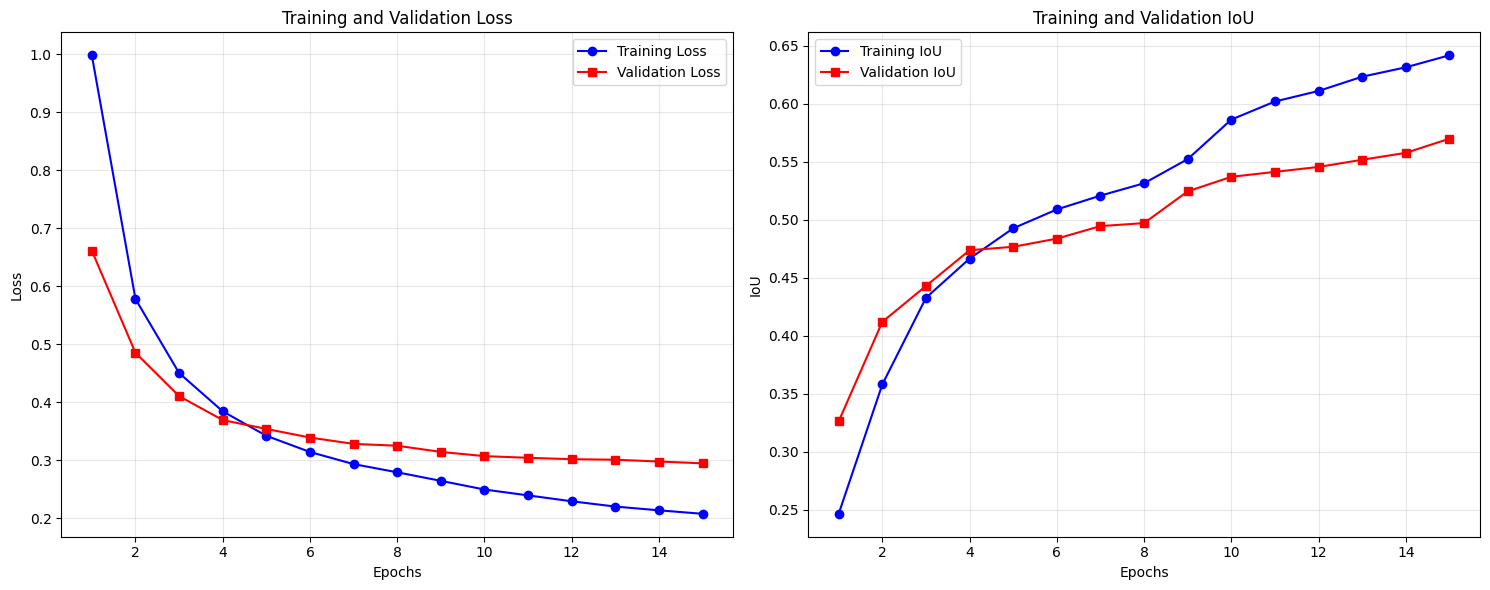

=== TRAINING SUMMARY ===
Final Training Loss: 0.2081
Final Validation Loss: 0.2950
Final Training IoU: 0.6417
Final Validation IoU: 0.5698
Best Validation IoU: 0.5698 (Epoch 15)
Best Training IoU: 0.6417 (Epoch 15)


In [3]:
plot_training_metrics_from_checkpoint(15)

In [ ]:
resume_from_epoch = 15  # 0 means start from scratch
additional_epochs = 5  # Number of epochs to train
print(f"check, size is now {syn_dataset[0][0].shape}")
if resume_from_epoch > 0:
    checkpoint_path = f"models/unet_imagenet1k_480x256_epoch_{resume_from_epoch}.pth"
    print(f"Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    train_ious = checkpoint['train_ious']
    val_losses = checkpoint['val_losses']
    val_ious = checkpoint['val_ious']
    best_val_iou = max(val_ious)
    print(f"Previous best validation IoU: {best_val_iou:.4f}")
    total_epochs = start_epoch + additional_epochs
    print(f"Resuming training from epoch {start_epoch} to {total_epochs}")
else:
    print("Starting training from scratch.")
    start_epoch = 0
    total_epochs = additional_epochs
    train_losses = []
    train_ious = []
    val_losses = []
    val_ious = []
    best_val_iou = 0.0
    os.makedirs("models", exist_ok=True)    

In [ ]:
new_seed = SEED + start_epoch  
syn_train_dataloader = DataLoader(
    syn_train_dataset,  # Keep the same dataset split
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator().manual_seed(new_seed)
)
syn_val_dataloader = DataLoader(
    syn_val_dataset,  # Keep the same dataset split
    batch_size=batch_size,
    shuffle=True,  
    generator=torch.Generator().manual_seed(new_seed)
)

start = time.time()
set_seeds(new_seed)
for epoch in range(start_epoch, total_epochs):
    print(f"Epoch {epoch+1}/{total_epochs}")
    train_loss, train_iou, val_loss, val_iou = train_and_validate_epoch(
        model, syn_train_dataloader, syn_val_dataloader, optimizer, criterion
    )
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
    checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
        "train_iou": train_iou,
        "val_loss": val_loss,
        "val_iou": val_iou,
        "train_losses": train_losses,
        "train_ious": train_ious,
        "val_losses": val_losses,
        "val_ious": val_ious,
        "num_classes": NUM_CLASSES,
        "learning_rate": LR,
    }
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        best_model_path = "models/unet_imagenet1k_480x256_best_model.pth"
        torch.save(checkpoint, best_model_path)
        print(f"New best model saved: {best_model_path} (Val IoU: {val_iou:.4f})")
    checkpoint_path = f"models/unet_imagenet1k_480x256_epoch_{epoch+1}.pth"
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")
    checkpoint_delete = f"models/unet_imagenet1k_480x256_epoch_{epoch}.pth"
    if os.path.exists(checkpoint_delete):
        os.remove(checkpoint_delete)
        print(f"Deleted old checkpoint: {checkpoint_delete}")
    del checkpoint
    print("-" * 50)
end = time.time()
print(f"\nTraining completed in {end - start:.2f} seconds, with {total_epochs - start_epoch} epochs.")
print(f"Best validation IoU: {best_val_iou:.4f}")
print(f"Final model saved as: models/unet_imagenet1k_480x256_epoch_{total_epochs}.pth")
print(f"Best model saved as: models/unet_imagenet1k_480x256_best_model.pth")

### Training Log (Continued)

**Loading checkpoint from:** models/unet_imagenet1k_480x256_epoch_15.pth  
**Previous best validation IoU:** 0.5698  
**Resuming training from epoch 15 to 20**

**Epoch 16/20**  
Training: 100% (938/938) [14:48<00:00, 1.06it/s]  
Validating: 100% (157/157) [01:05<00:00, 2.39it/s]  
Train Loss: 0.1990 | Train IoU: 0.6505  
Val Loss: 0.2809 | Val IoU: 0.5687  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_16.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_15.pth  

---

**Epoch 17/20**  
Training: 100% (938/938) [15:04<00:00, 1.04it/s]  
Validating: 100% (157/157) [01:07<00:00, 2.33it/s]  
Train Loss: 0.1860 | Train IoU: 0.6610  
Val Loss: 0.2838 | Val IoU: 0.5638  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_17.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_16.pth  

---

**Epoch 18/20**  
Training: 100% (938/938) [15:12<00:00, 1.03it/s]  
Validating: 100% (157/157) [01:09<00:00, 2.27it/s]  
Train Loss: 0.1800 | Train IoU: 0.6702  
Val Loss: 0.2778 | Val IoU: 0.5738  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5738)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_18.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_17.pth  

---

**Epoch 19/20**  
Training: 100% (938/938) [15:24<00:00, 1.01it/s]  
Validating: 100% (157/157) [01:13<00:00, 2.15it/s]  
Train Loss: 0.1748 | Train IoU: 0.6733  
Val Loss: 0.2853 | Val IoU: 0.5701  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_19.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_18.pth  

---

**Epoch 20/20**  
Training: 100% (938/938) [15:56<00:00, 1.02s/it]  
Validating: 100% (157/157) [01:14<00:00, 2.10it/s]  
Train Loss: 0.1701 | Train IoU: 0.6805  
Val Loss: 0.2737 | Val IoU: 0.5783  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5783)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_20.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_19.pth  

---

**Training completed in 4941.55 seconds, with 5 epochs.**  
Best validation IoU: 0.5783  
Final model saved as: `models/unet_imagenet1k_480x256_epoch_20.pth`  
Best model saved as: `models/unet_imagenet1k_480x256_best_model.pth`

---

**Loading checkpoint from:** models/unet_imagenet1k_480x256_epoch_20.pth  
**Previous best validation IoU:** 0.5783  
**Resuming training from epoch 20 to 25**

**Epoch 21/25**  
Training: 100% (938/938) [14:47<00:00, 1.06it/s]  
Validating: 100% (157/157) [01:05<00:00, 2.39it/s]  
Train Loss: 0.1661 | Train IoU: 0.6866  
Val Loss: 0.2687 | Val IoU: 0.5862  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5862)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_21.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_20.pth  

---

**Epoch 22/25**  
Training: 100% (938/938) [15:02<00:00, 1.04it/s]  
Validating: 100% (157/157) [01:07<00:00, 2.34it/s]  
Train Loss: 0.1587 | Train IoU: 0.6913  
Val Loss: 0.2621 | Val IoU: 0.5929  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5929)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_22.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_21.pth  

---

**Epoch 23/25**  
Training: 100% (938/938) [15:15<00:00, 1.02it/s]  
Validating: 100% (157/157) [01:10<00:00, 2.24it/s]  
Train Loss: 0.1507 | Train IoU: 0.7014  
Val Loss: 0.2620 | Val IoU: 0.5936  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5936)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_23.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_22.pth  

---

**Epoch 24/25**  
Training: 100% (938/938) [15:34<00:00, 1.00it/s]  
Validating: 100% (157/157) [01:13<00:00, 2.14it/s]  
Train Loss: 0.1472 | Train IoU: 0.7035  
Val Loss: 0.2571 | Val IoU: 0.5983  
_New best model saved: models/unet_imagenet1k_480x256_best_model.pth (Val IoU: 0.5983)_  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_24.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_23.pth  

---

**Epoch 25/25**  
Training: 100% (938/938) [15:54<00:00, 1.02s/it]  
Validating: 100% (157/157) [01:14<00:00, 2.11it/s]  
Train Loss: 0.1453 | Train IoU: 0.7046  
Val Loss: 0.2638 | Val IoU: 0.5906  
Checkpoint saved: models/unet_imagenet1k_480x256_epoch_25.pth  
Deleted old checkpoint: models/unet_imagenet1k_480x256_epoch_24.pth  

---

**Training completed in 4951.80 seconds, with 5 epochs.**  
Best validation IoU: 0.5983  
Final model saved as: `models/unet_imagenet1k_480x256_epoch_25.pth`  
Best model saved as: `models/unet_imagenet1k_480x256_best_model.pth`

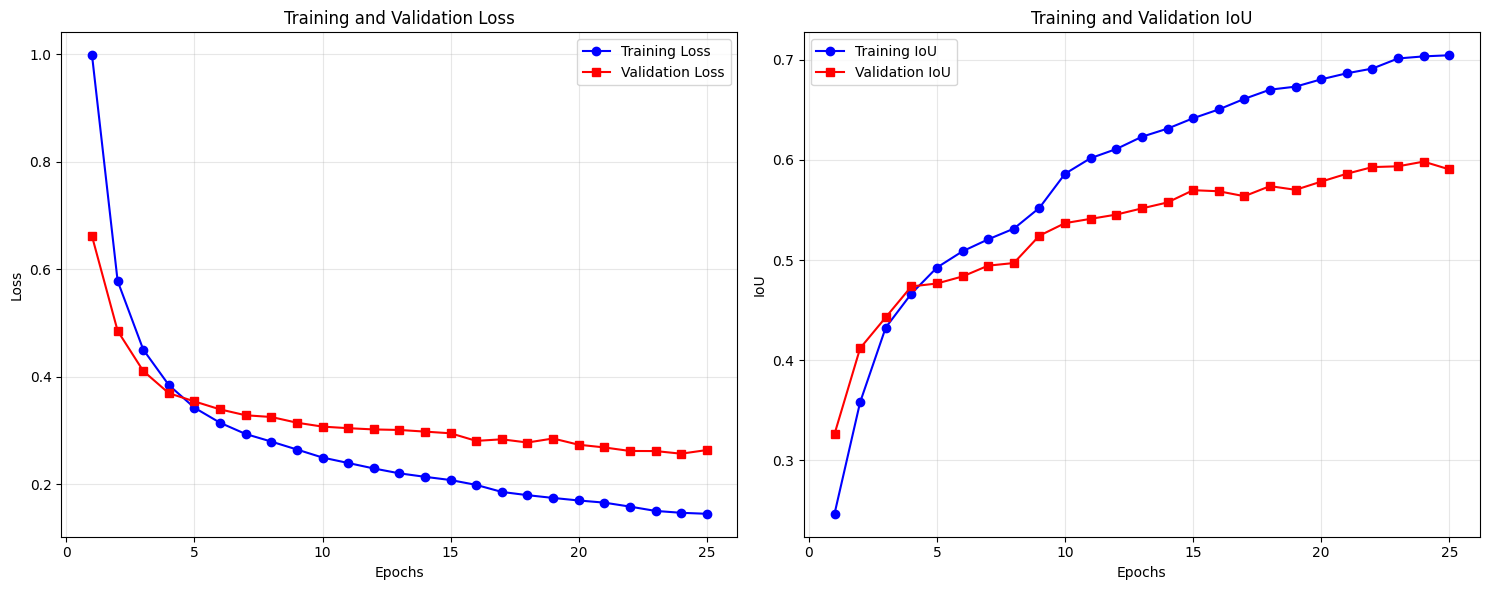

=== TRAINING SUMMARY ===
Final Training Loss: 0.1453
Final Validation Loss: 0.2638
Final Training IoU: 0.7046
Final Validation IoU: 0.5906
Best Validation IoU: 0.5983 (Epoch 24)
Best Training IoU: 0.7046 (Epoch 25)


In [19]:
plot_training_metrics_from_checkpoint(25)

Best model loaded from models/unet_imagenet1k_480x256_best_model.pth
Visualizing segmentation results on validation set:


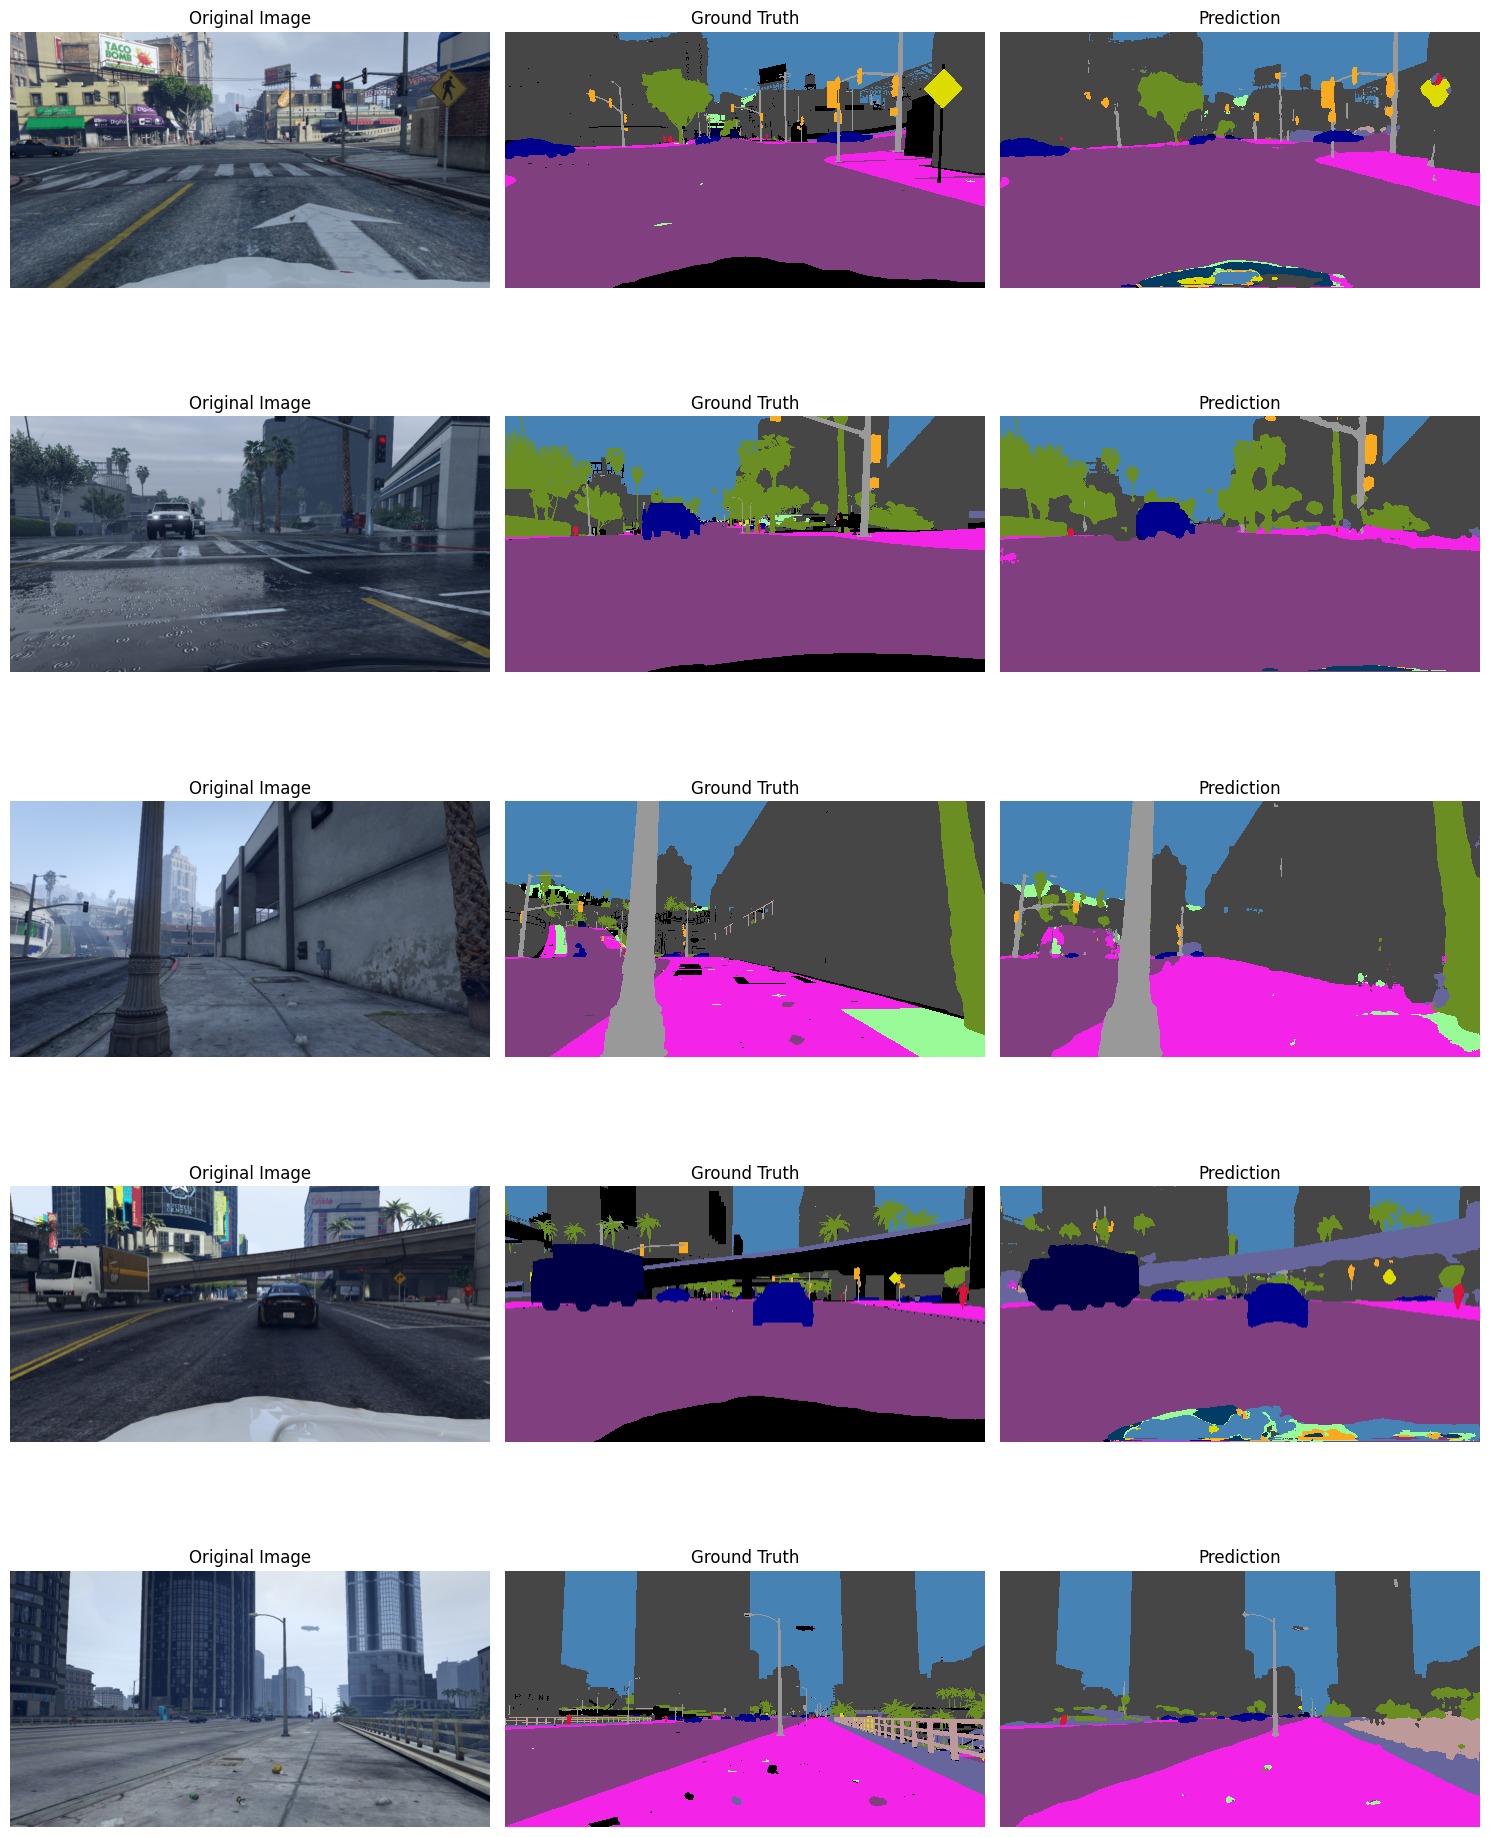

Visualizing segmentation results on training set:


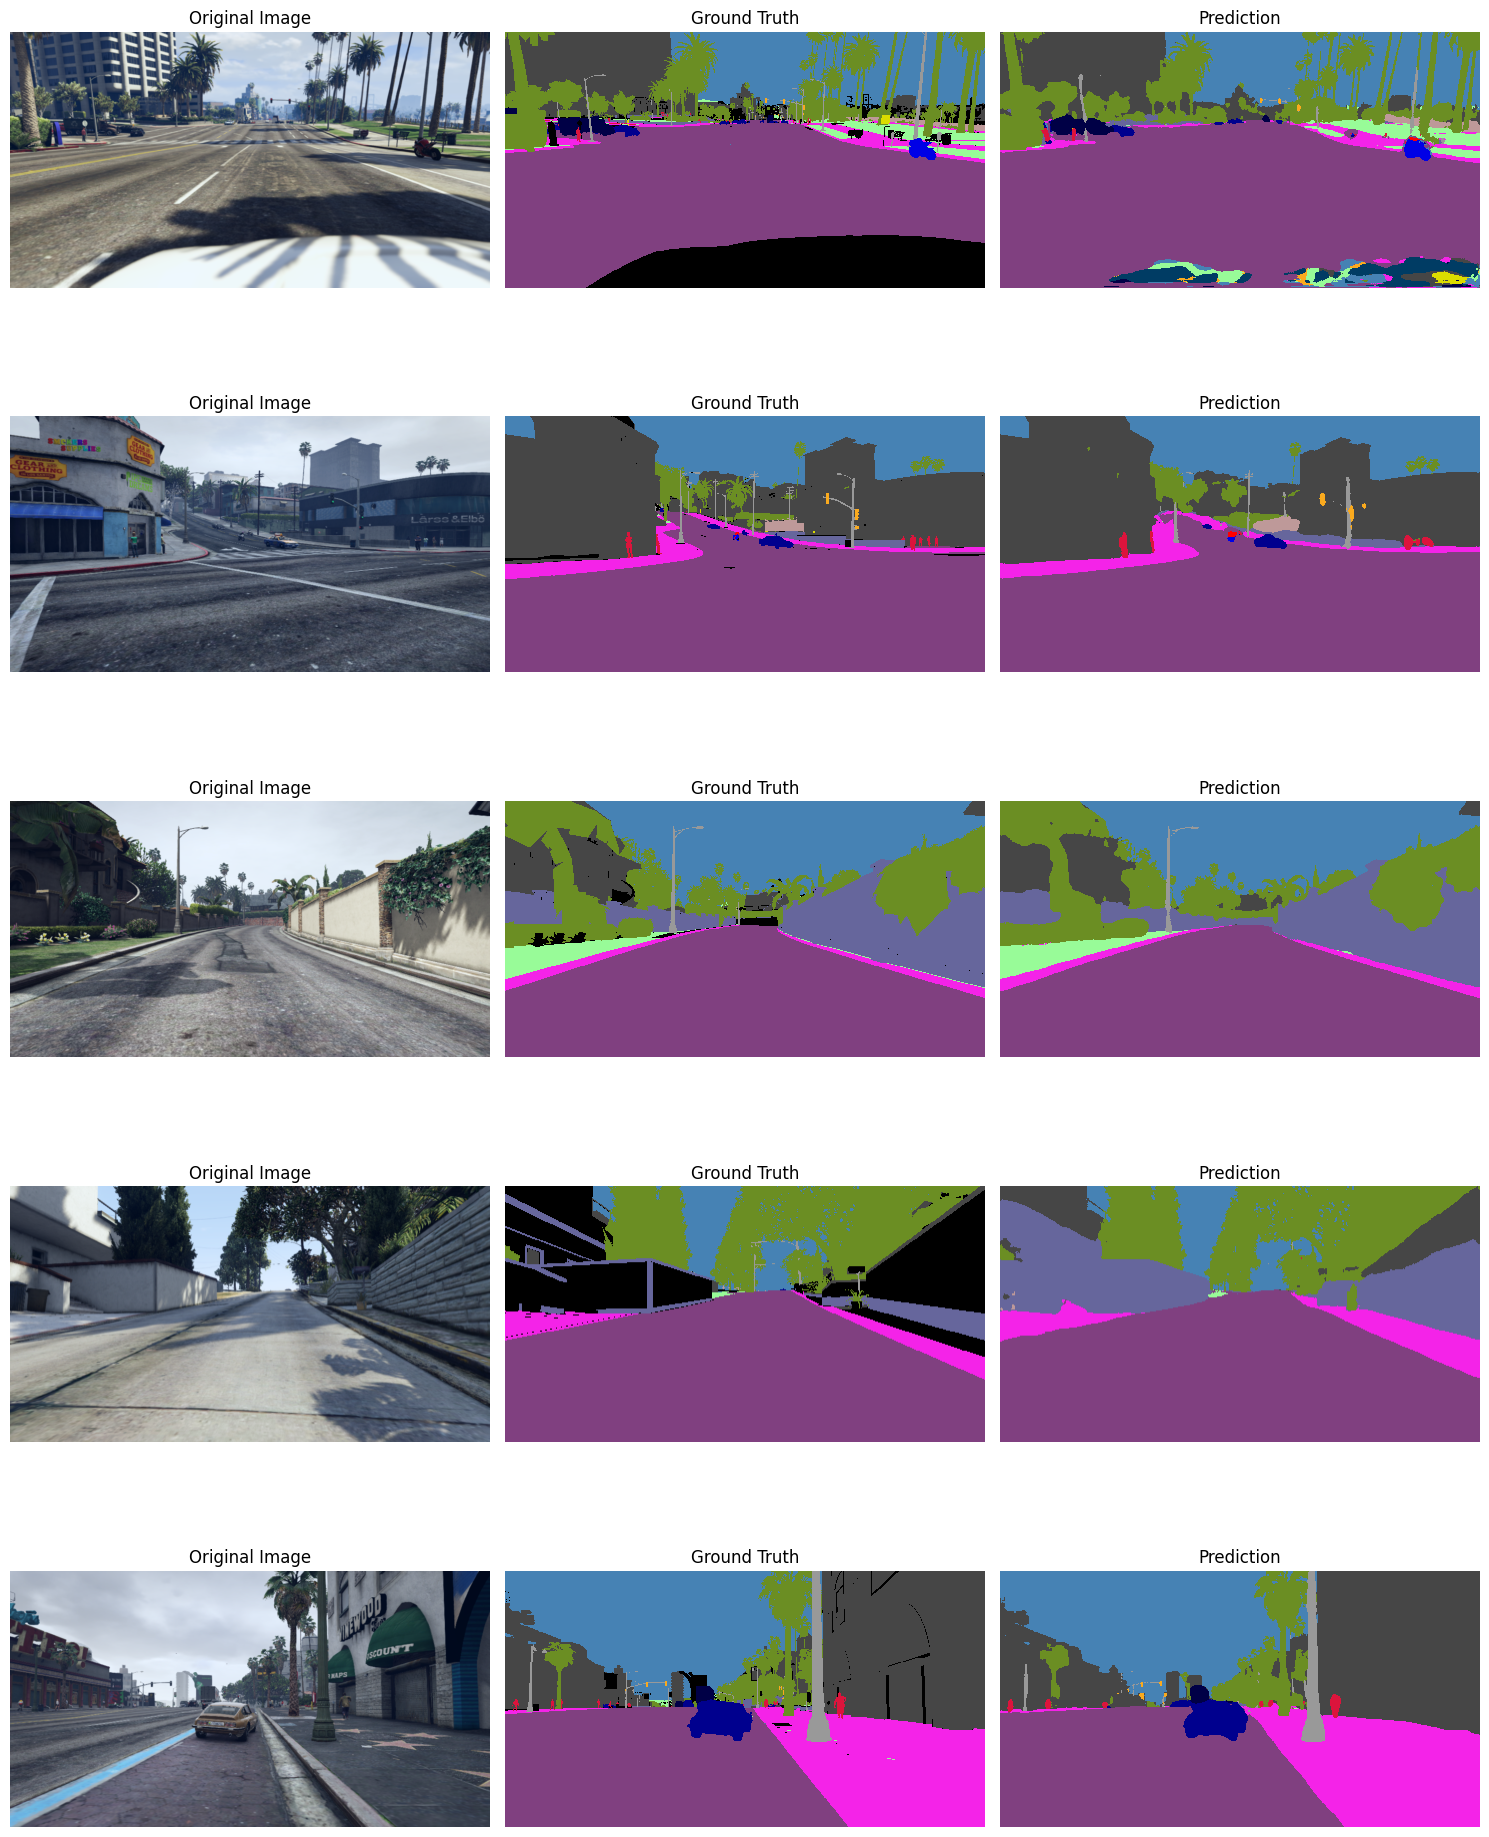

In [22]:
best_model_path = "models/unet_imagenet1k_480x256_best_model.pth"
# Load the best model from checkpoint
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model loaded from {best_model_path}")

print("Visualizing segmentation results on validation set:")
visualize_segmentation(model, syn_val_dataloader, num_samples=5)
print("Visualizing segmentation results on training set:")
visualize_segmentation(model, syn_train_dataloader, num_samples=5)